In [39]:
import sionna.rt
import xarray as xr
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
import yaml
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies, AntennaPattern


print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)


Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
# select GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("GPU:", gpus)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("Using GPU:", gpus[0].name)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

else:
  print("No GPU found, using CPU.")



GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
Using GPU: /physical_device:GPU:0


I0000 00:00:1761641881.540524  499493 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13741 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# Load scene
scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

2025-10-28 08:58:03 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [4]:
# open interactive window to preview the scene (this takes a while)
scene.preview();


In [5]:
# load the config file
def load_config(path='/home/user/6GTandem_RT_server/src_ant_pat_plus_movement/config.yaml'):
    with open(path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# load config file
config = load_config()




In [ ]:
""" dummy analautic pattern definition """
class CustomDirectionalPattern(AntennaPattern):
    """
    A simple directional antenna pattern defined analytically.
    Returns E_theta and E_phi components.
    """

    def __init__(self, n=4, k=2*np.pi):
        super().__init__()
        self.n = n
        self.k = k

    @property
    def patterns(self):
        def f(theta, phi):
            theta = tf.cast(theta, tf.float32)
            phi = tf.cast(phi, tf.float32)

            # amplitude term
            mag = tf.math.cos(theta) ** self.n

            # phase term
            phase_angle = self.k * tf.math.sin(theta) * tf.math.cos(phi)
            phase = tf.complex(tf.math.cos(phase_angle), tf.math.sin(phase_angle))

            field = tf.cast(mag, tf.complex64) * phase

            # Must return a tuple of (E_theta, E_phi)
            # For simplicity, we assume only theta-polarized radiation
            E_theta = field
            E_phi = tf.zeros_like(field)

            return (E_theta, E_phi)

        # For a single polarization antenna, return list of one pattern
        return [f]


def my_pattern_factory(n=8):
    """Factory method that returns an instance of the antenna pattern"""
    return CustomDirectionalPattern(n=n)

# Register it under a custom name
sionna.rt.register_antenna_pattern("custom_analytic", my_pattern_factory)

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

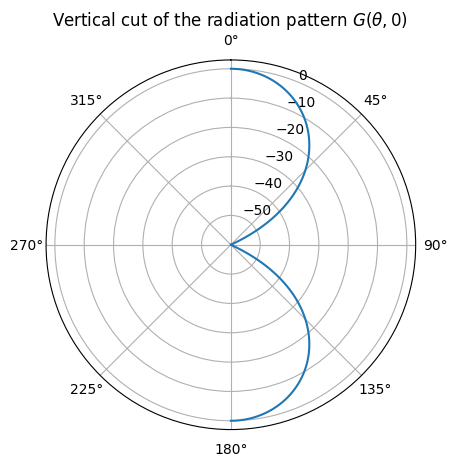

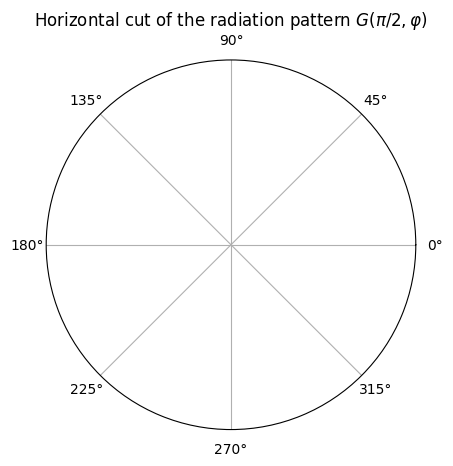

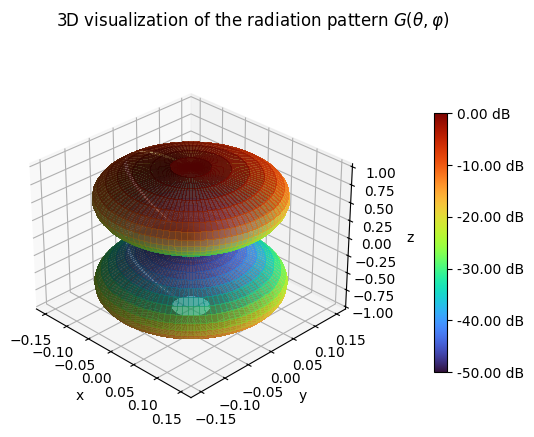

In [7]:
# create antenna array based and plot antenna pattern
scene.tx_array = PlanarArray(num_rows=1,#config['antenna_config']['N_antenna_rows'],
                                num_cols=1,#config['antenna_config']['N_antenna_cols'],
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="custom_analytic")
                                #polarization=config['antenna_config']['polarization'])

scene.tx_array.antenna_pattern.show()

max mag: 13.110299999999999
max index mag: 59314
len mag: 130321
max gain field before normalization: 13.1103
max gain before normalization: 11.176126296652086 dB


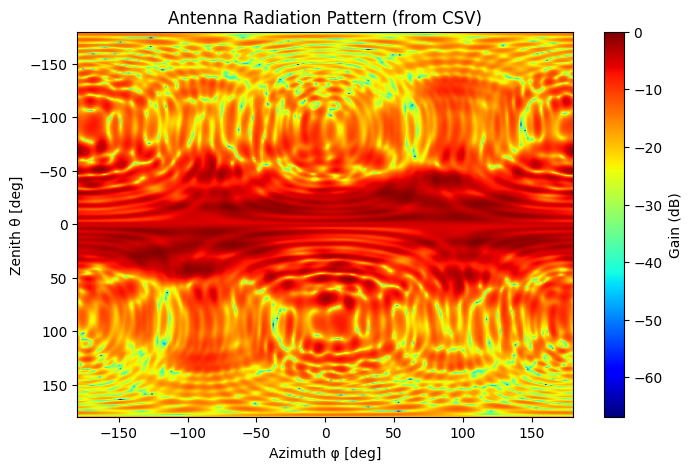

max mag: 13.110299999999999
max index mag: 59314
len mag: 130321
max gain field before normalization: 13.1103
max gain before normalization: 11.176126296652086 dB


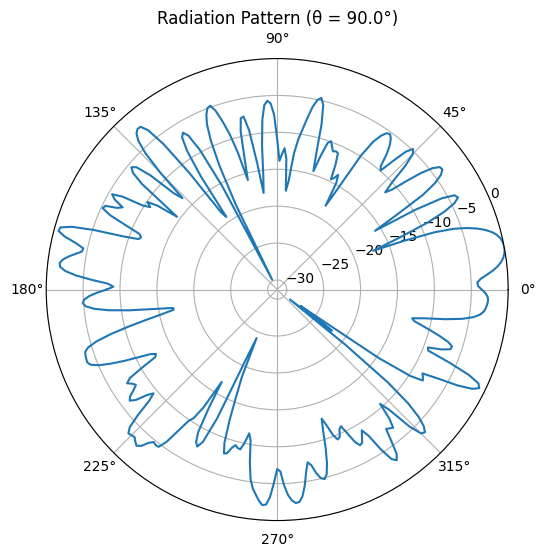

max mag: 13.110299999999999
max index mag: 59314
len mag: 130321
max gain field before normalization: 13.1103
max gain before normalization: 11.176126296652086 dB


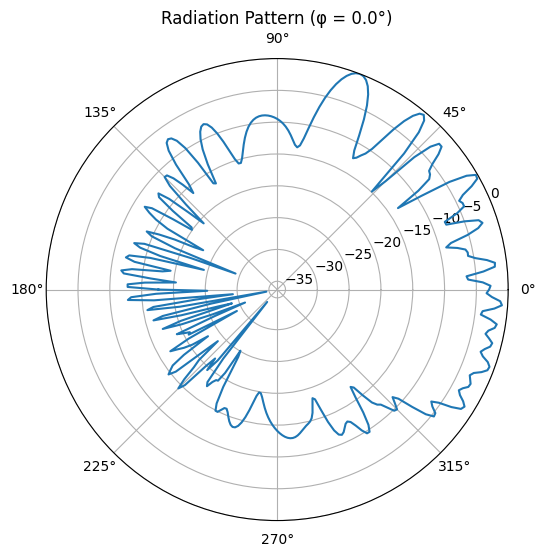

max mag: 13.110299999999999
max index mag: 59314
len mag: 130321
max gain field before normalization: 13.1103
max gain before normalization: 11.176126296652086 dB


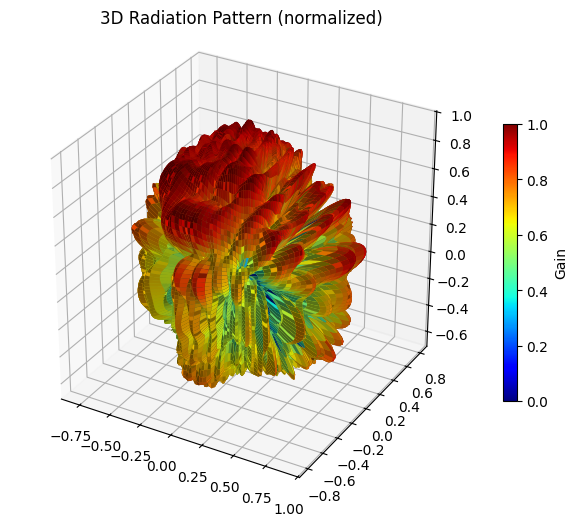

plot from sionna code
g_db_min: 0.0, g_db_max: 1.0


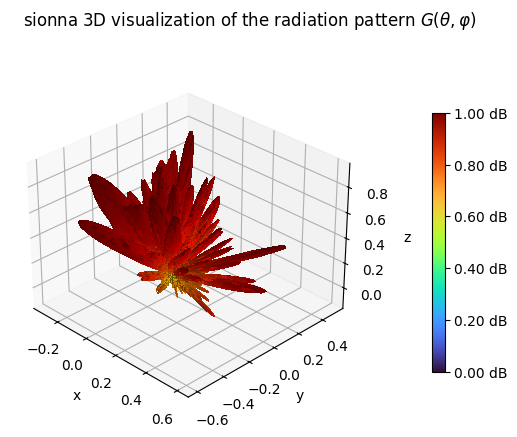

In [ ]:
""" plot purly from csv data """
# plot without sionna (this is correct!! => sionna not!!)
def plot_antenna_pattern_from_csv(
    csv_path,
    normalize=True,
    dB=True,
    plot_type="heatmap",
    theta_slice=None,
    phi_slice=None,
    dynamic_range_dB=40
):
    """
    Plot a radiation pattern directly from CSV antenna data.

    Parameters
    ----------
    csv_path : str
        Path to CSV file containing columns:
        'Phi[deg]', 'Theta[deg]', 'mag(rERHCP)[mV]', 'ang_deg(rERHCP)[deg]'
    normalize : bool
        If True, normalize |E| to its maximum value.
    dB : bool
        If True, plot gain in dB.
    plot_type : str
        "heatmap", "polar", or "3d"
    theta_slice : float, optional
        For "polar" plot: fix theta and vary phi.
    phi_slice : float, optional
        For "polar" plot: fix phi and vary theta.
    dynamic_range_dB : float
        Minimum dB level to show in 3D plot.
    """

    # ---- Load CSV ----
    df = pd.read_csv(csv_path)
    theta = np.deg2rad(df["Theta[deg]"].values)
    phi = np.deg2rad(df["Phi[deg]"].values)
    mag = df["mag(rERHCP)[mV]"].values / 1000  # convert mV to V
    ang = np.deg2rad(df["ang_deg(rERHCP)[deg]"].values)

    # Complex field
    field = mag * np.exp(1j * ang)


    # Normalize
    if normalize:
        # print max gain before normalization
        print(f'max mag: {np.max(mag)}')
        print(f'max index mag: {np.argmax(mag)}')
        print(f'len mag: {len(mag)}')
        print(f'max gain field before normalization: {np.max(np.abs(field))}')
        print(f'max gain before normalization: {10*np.log10(np.max(np.abs(field)))} dB')

        # normalize field
        field /= np.max(np.abs(field))

    # Build 2D grid
    theta_unique = np.sort(np.unique(theta))
    phi_unique = np.sort(np.unique(phi))
    n_theta, n_phi = len(theta_unique), len(phi_unique)

    field_grid = field.reshape(n_theta, n_phi)
    E_theta = field_grid / np.sqrt(2)
    E_phi   = 1j * field_grid / np.sqrt(2)
    gain = np.abs(E_theta)**2 + np.abs(E_phi)**2
    gain_db = 10*np.log10(gain)
    # gain = np.abs(field_grid)**2
    # gain_db = 10*np.log10(gain)
    #gain_db = 20 * np.log10(np.abs(field_grid) / np.max(np.abs(field_grid)))
    #gain_db = np.clip(gain_db, -dynamic_range_dB, None)

    # ---- 2D heatmap ----
    if plot_type == "heatmap":
        plt.figure(figsize=(8, 5))
        plt.imshow(
            gain_db if dB else gain,
            extent=[np.rad2deg(phi_unique[0]), np.rad2deg(phi_unique[-1]),
                    np.rad2deg(theta_unique[-1]), np.rad2deg(theta_unique[0])],
            aspect='auto', cmap="jet"
        )
        plt.colorbar(label="Gain (dB)" if dB else "|E|")
        plt.xlabel("Azimuth φ [deg]")
        plt.ylabel("Zenith θ [deg]")
        plt.title("Antenna Radiation Pattern (from CSV)")
        plt.show()

    # ---- 1D polar cut ----
    elif plot_type == "polar":
        if theta_slice is not None:
            idx = np.argmin(np.abs(theta_unique - np.deg2rad(theta_slice)))
            pattern = gain_db[idx, :] if dB else gain[idx, :]
            phi_deg = np.rad2deg(phi_unique)
            plt.figure(figsize=(6,6))
            plt.polar(np.deg2rad(phi_deg), pattern - np.max(pattern))
            plt.title(f"Radiation Pattern (θ = {theta_slice:.1f}°)")
            plt.show()
        elif phi_slice is not None:
            idx = np.argmin(np.abs(phi_unique - np.deg2rad(phi_slice)))
            pattern = gain_db[:, idx] if dB else gain[:, idx]
            theta_deg = np.rad2deg(theta_unique)
            plt.figure(figsize=(6,6))
            plt.polar(np.deg2rad(theta_deg), pattern - np.max(pattern))
            plt.title(f"Radiation Pattern (φ = {phi_slice:.1f}°)")
            plt.show()
        else:
            raise ValueError("Provide either theta_slice or phi_slice for polar plot.")

    # ---- 3D spherical plot ----
    elif plot_type == "3d":
        TH, PHI = np.meshgrid(theta_unique, phi_unique, indexing="ij")

        # Convert spherical to Cartesian coordinates
        r = np.abs(field_grid)**2
        if dB:
            #r = 10 * np.log10(r)  # absolute dB values, no normalization
            #r = np.clip(r, np.max(r) - dynamic_range_dB, np.max(r))  # limit dynamic range for clarity
            # Optional: shift dB scale so the strongest point is at 0 dB (for consistent visualization)
            #r = r - np.max(r)


            r = np.clip(10*np.log10(r/np.max(r)), -dynamic_range_dB, 0)
            r = (r + dynamic_range_dB) / dynamic_range_dB  # normalize [0,1]

        # r_linear = (r - np.min(r)) / (np.max(r) - np.min(r))  # map dB values to 0–1 for shape plotting
        # X = r_linear * np.sin(TH) * np.cos(PHI)
        # Y = r_linear * np.sin(TH) * np.sin(PHI)
        # Z = r_linear * np.cos(TH)
        X = r * np.sin(TH) * np.cos(PHI)
        Y = r * np.sin(TH) * np.sin(PHI)
        Z = r * np.cos(TH)

        # # --- color normalization for facecolors ---
        # norm = Normalize(vmin=np.min(r), vmax=np.max(r))
        # colors = cm.jet(norm(r))  # map dB values to color scale
        # # --- plot ---
        # fig = plt.figure(figsize=(8, 6))
        # ax = fig.add_subplot(111, projection="3d")
        # surf = ax.plot_surface(X, Y, Z, facecolors=colors,
        #                     rstride=2, cstride=2,
        #                     linewidth=0, antialiased=True, alpha=0.9)

        # mappable = cm.ScalarMappable(norm=norm, cmap='jet')
        # mappable.set_array(r)
        # fig.colorbar(mappable, ax=ax, shrink=0.6, label="Gain (dB)")

        # ax.set_box_aspect([1, 1, 1])
        # ax.set_title("3D Radiation Pattern (raw dB color scale)")
        # plt.show()


        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")
        norm = Normalize(vmin=np.min(r), vmax=np.max(r))
        colors = cm.jet(norm(r))  # map dB values to color scale
        mappable = cm.ScalarMappable(norm=norm, cmap='jet')
        mappable.set_array(r)
        fig.colorbar(mappable, ax=ax, shrink=0.6, label="Gain")

        surf = ax.plot_surface(X, Y, Z, facecolors=colors, rstride=2, cstride=2,
                               linewidth=0, antialiased=True, alpha=0.9)

        ax.set_box_aspect([1, 1, 1])
        ax.set_title("3D Radiation Pattern (normalized)")
        plt.show()

        print(f'plot from sionna code')

            # 3D visualization
        theta_grid, phi_grid = np.meshgrid(theta_unique, phi_unique, indexing="ij")
        g = np.abs(field_grid)**2
        x = g * np.sin(theta_grid) * np.cos(phi_grid)
        y = g * np.sin(theta_grid) * np.sin(phi_grid)
        z = g * np.cos(theta_grid)
        #g = np.maximum(g, 1e-5)
        g_db = 10*np.log10(g)

        g_db = np.clip(10*np.log10(g/np.max(g)), -dynamic_range_dB, 0)
        g_db = (g_db + dynamic_range_dB) / dynamic_range_dB  # normalize [0,1]

        def norm(x, x_max, x_min):
            """Maps input to [0,1] range"""
            x = 10**(x/10)
            x_max = 10**(x_max/10)
            x_min = 10**(x_min/10)
            if x_min==x_max:
                x = np.ones_like(x)
            else:
                x -= x_min
                x /= np.abs(x_max-x_min)
            return x

        g_db_min = np.min(g_db)
        g_db_max = np.max(g_db)
        print(f'g_db_min: {g_db_min}, g_db_max: {g_db_max}')


        norm = Normalize(vmin=np.min(g_db), vmax=np.max(g_db))
        colors = cm.jet(norm(g_db))  # map dB values to color scale

        fig_3d = plt.figure()
        ax = fig_3d.add_subplot(1,1,1, projection='3d')
        ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                        antialiased=False, alpha=0.7,
                        facecolors=colors) # set back to norm

        sm = cm.ScalarMappable(cmap=plt.cm.turbo)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation="vertical", location="right",
                            shrink=0.7, pad=0.15)
        xticks = cbar.ax.get_yticks()
        xticklabels = cbar.ax.get_yticklabels()
        xticklabels = g_db_min + xticks*(g_db_max-g_db_min)
        xticklabels = [f"{z:.2f} dB" for z in xticklabels]
        cbar.ax.set_yticks(xticks)
        cbar.ax.set_yticklabels(xticklabels)

        ax.view_init(elev=30., azim=-45)
        plt.xlabel("x")
        plt.ylabel("y")
        ax.set_zlabel("z")
        plt.suptitle(
            r"sionna 3D visualization of the radiation pattern $G(\theta,\varphi)$")
    else:
        raise ValueError("plot_type must be 'heatmap', 'polar', or '3d'.")


    

path = r'/home/user/6GTandem_RT_server/antenna_patterns/element1.csv'

# Full 2D pattern
plot_antenna_pattern_from_csv(path)

# 1D azimuth cut at θ = 90°
plot_antenna_pattern_from_csv(path, plot_type="polar", theta_slice=90)

# 1D elevation cut at φ = 0°
plot_antenna_pattern_from_csv(path, plot_type="polar", phi_slice=0)

# 3D radiation lobe visualization
plot_antenna_pattern_from_csv(path, plot_type="3d")




In [ ]:
""" custom patterns for sionna based on measurements """
# antenna pattern based on measurements
class MeasuredPattern(AntennaPattern):
    """
    Custom antenna pattern based on CSV data.
    The CSV must contain columns:
    'Phi[deg]', 'Theta[deg]', 'mag(rERHCP)[mV]', 'ang_deg(rERHCP)[deg]'
    """

    def __init__(self, csv_path, normalize=True):
        super().__init__()

        # ---- Load CSV ----
        df = pd.read_csv(csv_path)
        phi_deg = df["Phi[deg]"].values # degrees
        theta_deg = df["Theta[deg]"].values # degrees
        mag = df["mag(rERHCP)[mV]"].values/1000  # convert mV to V
        print(f'max mag in MeasuredPattern: {np.max(mag)*1000} mV')
        ang_deg = df["ang_deg(rERHCP)[deg]"].values

        # ---- Convert to radians and complex field ----
        phi = np.deg2rad(phi_deg)
        theta = np.deg2rad(theta_deg)
        field = mag * np.exp(1j * np.deg2rad(ang_deg))

        # Optional normalization (to make max field = 1)
        if normalize:
            field = field / np.max(np.abs(field))

        # ---- Build regular grids for interpolation ----
        # (assuming uniform or nearly-uniform sampling)
        phi_unique = np.sort(np.unique(phi))
        theta_unique = np.sort(np.unique(theta))

        # reshape to 2D grid [len(theta), len(phi)]
        n_theta = len(theta_unique)
        n_phi = len(phi_unique)

        field_grid = field.reshape(n_theta, n_phi)



        # Interpolator over (theta, phi)
        self._interp = RegularGridInterpolator(
            (theta_unique, phi_unique),
            field_grid,
            bounds_error=False,
            fill_value=1e-8
        )

    @property
    def patterns(self):
        def f(theta, phi):
            # Convert TF tensors to numpy arrays for interpolation
            theta_np = theta.numpy()
            phi_np = phi.numpy()

            # # Apply a phi offset todo debug
            # phi_offset_rad = np.deg2rad(270)  # example: rotate 180°
            # phi_np = (phi_np + phi_offset_rad) % (2*np.pi)


            # Stack and interpolate
            pts = np.stack([theta_np, phi_np], axis=-1)
            field_np = self._interp(pts)

            # Convert back to TF complex tensor
            field = tf.constant(field_np, dtype=tf.complex64)

            # Convert from circular (RHCP) to linear components
            E_theta = field / tf.constant(np.sqrt(2), tf.complex64)
            E_phi   = 1j * field / tf.constant(np.sqrt(2), tf.complex64)
            return (E_theta, E_phi)

        # Single polarization (RHCP)
        return [f]

# register all measured patterns
for i in range(1, 5):
    path = f'/home/user/6GTandem_RT_server/antenna_patterns/element{i}.csv'

    def measured_pattern_factory(csv_path=path, normalize=False):
        """Factory method that returns an instance of the antenna pattern"""
        return MeasuredPattern(csv_path=csv_path, normalize=normalize)

    # Register it under a custom name
    sionna.rt.register_antenna_pattern(f"custom_measured_element_{i}", measured_pattern_factory)




In [157]:
"""add element of choice to sionna """

element_idx = 4 # select element
# create antenna array based and plot antenna pattern
scene.tx_array = PlanarArray(num_rows=1, #config['antenna_config']['N_antenna_rows'],
                                num_cols=1, #config['antenna_config']['N_antenna_cols'],
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=f"custom_measured_element_{element_idx}")
                                #polarization=config['antenna_confi

# check the pattern 
phi_deg, theta_deg  = -180,-180
phi = np.deg2rad(phi_deg)
theta = np.deg2rad(theta_deg)
E_theta, E_phi = scene.tx_array.antenna_pattern.patterns[0](tf.constant(theta), tf.constant(phi))
gain = np.abs(E_theta)**2 + np.abs(E_phi)**2
print(f'gain at (θ={theta_deg}°, φ={phi_deg}°): {gain}')
print(f'magnitude at (θ={theta_deg}°, φ={phi_deg}°): {np.sqrt(gain)*1000} mV')
gain_db = 10*np.log10(gain)
print(f'gain in db: {gain_db}')





max mag in MeasuredPattern: 15960.5 mV
gain at (θ=-180°, φ=-180°): [1.0714942]
magnitude at (θ=-180°, φ=-180°): [1035.13] mV
gain in db: [0.29989833]


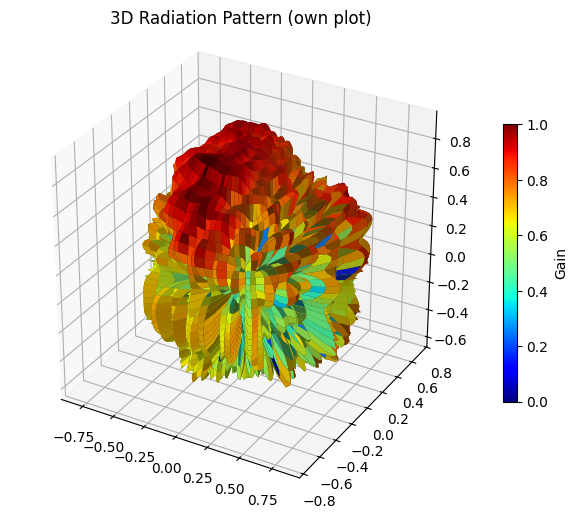

max magnitude in vertical cut: 11233.4912109375 mV
g_db_min: -5.752894878387451, g_db_max: 21.01029396057129


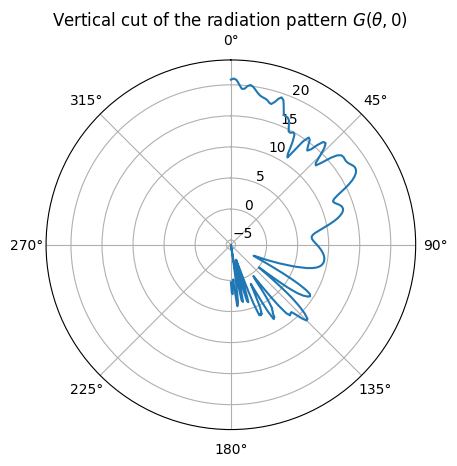

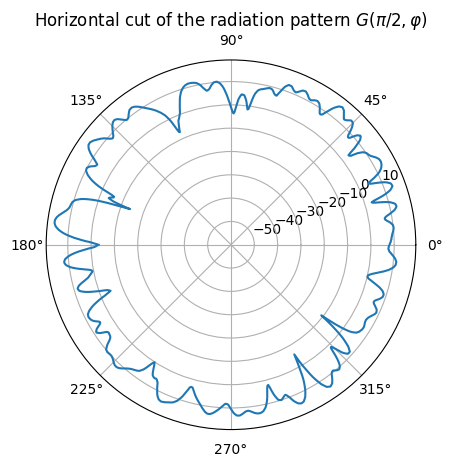

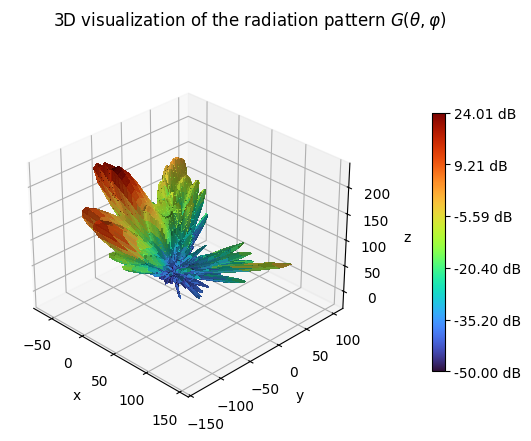

In [158]:
import drjit as dr
import mitsuba as mi

# load pattern from sionna
pattern = scene.tx_array.antenna_pattern.patterns[0]


# """ own plot through sionna data => looks the same => should be okay!!"""
dynamic_range_dB = 40
n = 200 # sample steps
theta = dr.linspace(mi.Float, -dr.pi, dr.pi, n, False)
phi = dr.linspace(mi.Float, -dr.pi, dr.pi, n, False)
theta_grid, phi_grid = dr.meshgrid(theta, phi, indexing='ij')
c_theta, c_phi = pattern(theta_grid, phi_grid)
c_theta, c_phi = pattern(theta_grid, phi_grid)
theta_grid = np.reshape(theta_grid, [n, n])
phi_grid = np.reshape(phi_grid, [n, n])
c_theta = np.reshape(c_theta, [n, n])
c_phi = np.reshape(c_phi, [n, n])
g = np.abs(c_theta)**2 + np.abs(c_phi)**2

# Convert spherical to Cartesian coordinates
r = g
r = np.clip(10*np.log10(r/np.max(r)), -dynamic_range_dB, 0)
r = (r + dynamic_range_dB) / dynamic_range_dB  # normalize [0,1]

X = r * np.sin(theta_grid) * np.cos(phi_grid)
Y = r * np.sin(theta_grid) * np.sin(phi_grid)
Z = r * np.cos(theta_grid)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
norm = Normalize(vmin=np.min(r), vmax=np.max(r))
colors = cm.jet(norm(r))  # map dB values to color scale
mappable = cm.ScalarMappable(norm=norm, cmap='jet')
mappable.set_array(r)
fig.colorbar(mappable, ax=ax, shrink=0.6, label="Gain")

surf = ax.plot_surface(X, Y, Z, facecolors=colors, rstride=2, cstride=2,
                        linewidth=0, antialiased=True, alpha=0.9)

ax.set_box_aspect([1, 1, 1])
ax.set_title("3D Radiation Pattern (own plot)")
plt.show()

""" builtin sionna plot => strange normalization """
theta = dr.linspace(mi.Float, 0, dr.pi, 1000)
phi = dr.zeros(mi.Float, 1000)
c_theta, c_phi = [c.numpy() for c in pattern(theta, phi)]
g = np.abs(c_theta)**2 + np.abs(c_phi)**2
magnitude = np.sqrt(g) * 1000  # in mV
print(f'max magnitude in vertical cut: {np.max(magnitude)} mV')
g = np.where(g==0, 1e-12, g)
g_db = 10*np.log10(g)
g_db_max = np.max(g_db)
g_db_min = np.min(g_db)
print(f'g_db_min: {g_db_min}, g_db_max: {g_db_max}')
if g_db_min==g_db_max:
    g_db_min = -30
else:
    g_db_min = np.maximum(-60., g_db_min)
fig_v = plt.figure()
plt.polar(theta.numpy(), g_db)
fig_v.axes[0].set_rmin(g_db_min)
fig_v.axes[0].set_rmax(g_db_max+3)
fig_v.axes[0].set_theta_zero_location("N")
fig_v.axes[0].set_theta_direction(-1)
plt.title(r"Vertical cut of the radiation pattern $G(\theta,0)$ ")

# Horizontal cut
theta = dr.pi/2*dr.ones(mi.Float, 1000)
phi = dr.linspace(mi.Float, -dr.pi, dr.pi, 1000)
c_theta, c_phi = [c.numpy() for c in pattern(theta, phi)]
g = np.abs(c_theta)**2 + np.abs(c_phi)**2
g = np.where(g==0, 1e-12, g)
g_db = 10*np.log10(g)
g_db_max = np.max(g_db)
g_db_min = np.min(g_db)
if (g_db_max - g_db_min)<0.1:
    g_db_min = -30
else:
    g_db_min = np.maximum(-60., g_db_min)

fig_h = plt.figure()
plt.polar(phi.numpy(), g_db)
fig_h.axes[0].set_rmin(g_db_min)
fig_h.axes[0].set_rmax(g_db_max+3)
fig_h.axes[0].set_theta_zero_location("E")
plt.title(r"Horizontal cut of the radiation pattern $G(\pi/2,\varphi)$")

# 3D visualization
n = 200 # sample steps
theta = dr.linspace(mi.Float, -dr.pi, dr.pi, n, False)
phi = dr.linspace(mi.Float, -dr.pi, dr.pi, n, False)
theta_grid, phi_grid = dr.meshgrid(theta, phi, indexing='ij')
c_theta, c_phi = pattern(theta_grid, phi_grid)
theta_grid = np.reshape(theta_grid, [n, n])
phi_grid = np.reshape(phi_grid, [n, n])
c_theta = np.reshape(c_theta, [n, n])
c_phi = np.reshape(c_phi, [n, n])
g = np.abs(c_theta)**2 + np.abs(c_phi)**2
x = g * np.sin(theta_grid) * np.cos(phi_grid)
y = g * np.sin(theta_grid) * np.sin(phi_grid)
z = g * np.cos(theta_grid)
g = np.maximum(g, 1e-5)
g_db = 10*np.log10(g)

def norm(x, x_max, x_min):
    """Maps input to [0,1] range"""
    x = 10**(x/10)
    x_max = 10**(x_max/10)
    x_min = 10**(x_min/10)
    if x_min==x_max:
        x = np.ones_like(x)
    else:
        x -= x_min
        x /= np.abs(x_max-x_min)
    return x

g_db_min = np.min(g_db)
g_db_max = np.max(g_db)

fig_3d = plt.figure()
ax = fig_3d.add_subplot(1,1,1, projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                antialiased=False, alpha=0.7,
                facecolors=cm.turbo(norm(g_db, g_db_max, g_db_min)))

sm = cm.ScalarMappable(cmap=plt.cm.turbo)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", location="right",
                    shrink=0.7, pad=0.15)
xticks = cbar.ax.get_yticks()
xticklabels = cbar.ax.get_yticklabels()
xticklabels = g_db_min + xticks*(g_db_max-g_db_min)
xticklabels = [f"{z:.2f} dB" for z in xticklabels]
cbar.ax.set_yticks(xticks)
cbar.ax.set_yticklabels(xticklabels)

ax.view_init(elev=30., azim=-45)
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel("z")
plt.suptitle(
    r"3D visualization of the radiation pattern $G(\theta,\varphi)$")
plt.show()

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

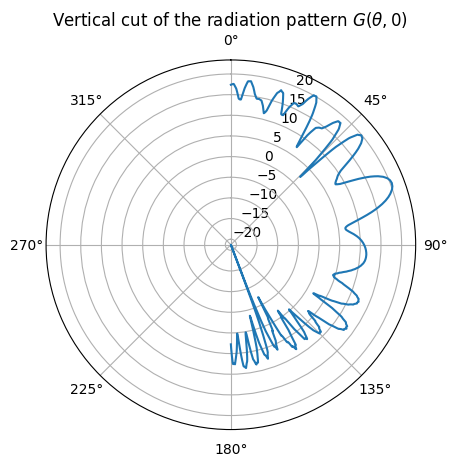

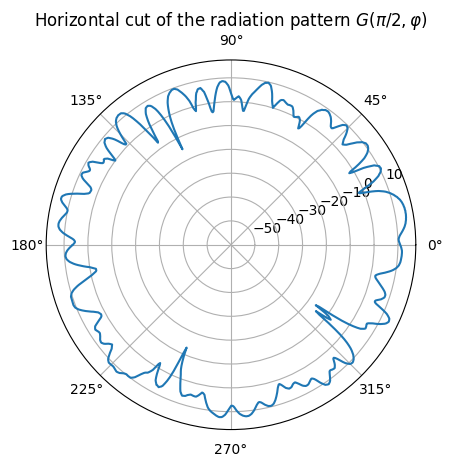

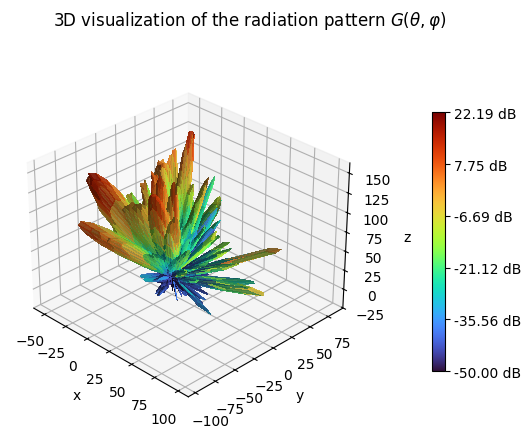

In [133]:
# create antenna array based and plot antenna pattern
scene.tx_array = PlanarArray(num_rows=1, #config['antenna_config']['N_antenna_rows'],
                                num_cols=1, #config['antenna_config']['N_antenna_cols'],
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="custom_measured")
                                #polarization=config['antenna_config']['polarization'])

scene.tx_array.antenna_pattern.show()

In [64]:
import numpy as np
# sionna
n = 100
theta = np.linspace(0, np.pi, n, endpoint=False)  # θ = 0 → zenith
phi = np.linspace(-np.pi, np.pi, n, endpoint=False)  # φ from -π to π
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

theta_tf = tf.convert_to_tensor(theta_grid, dtype=tf.float32)
phi_tf   = tf.convert_to_tensor(phi_grid, dtype=tf.float32)

pattern = measured_pattern_factory(path).patterns[0]
E_theta_tf, E_phi_tf = pattern(theta_tf, phi_tf)

# Convert back to NumPy for plotting
E_theta = E_theta_tf.numpy()
E_phi   = E_phi_tf.numpy()

gain = np.abs(E_theta)**2 + np.abs(E_phi)**2
gain_db = 10 * np.log10(gain)

print(f'from')
print("Gain (linear) min/max:", gain.min(), gain.max())
print("Gain (dB) min/max:", gain_db.min(), gain_db.max())

# csv 

# ---- Load CSV ----
csv_path = r'/home/user/6GTandem_RT_server/antenna_patterns/element1.csv'

df = pd.read_csv(csv_path)
theta = np.deg2rad(df["Theta[deg]"].values)
phi = np.deg2rad(df["Phi[deg]"].values)
mag = df["mag(rERHCP)[mV]"].values
ang = np.deg2rad(df["ang_deg(rERHCP)[deg]"].values)

# Complex field
field = mag * np.exp(1j * ang)
# normalize
field /= np.max(np.abs(field))


E_theta_csv = field / np.sqrt(2)
E_phi_csv   = 1j * field / np.sqrt(2)
gain_csv = np.abs(E_theta_csv)**2 + np.abs(E_phi_csv)**2
gain_db_csv = 10*np.log10(gain_csv)
print("CSV gain (linear) min/max:", gain_csv.min(), gain_csv.max())
print("CSV gain (dB) min/max:", gain_db_csv.min(), gain_db_csv.max())

from
Gain (linear) min/max: 9.9999995e-17 0.96316445
Gain (dB) min/max: -160.0 -0.16299558
CSV gain (linear) min/max: 2.0678861869095906e-07 0.9999999999999998
CSV gain (dB) min/max: -66.84473367781837 -9.643274665532873e-16
